In [ ]:
import warnings; warnings.simplefilter('ignore')
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
# from matplotlib.mlab import stineman_interp
import pandas as pd
import pandas_datareader as pddr
import requests
import zipfile as zi 
import io
from sklearn import datasets, linear_model
import scipy.special as scsp
import statsmodels.api as sm
import math
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')
DRIVE = '/content/drive/MyDrive/Colab Notebooks'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data preparation

In [ ]:
def download_oxford_data():
    url = 'https://realized.oxford-man.ox.ac.uk/images/oxfordmanrealizedvolatilityindices-0.2-final.zip'
    data = requests.get(url, stream=True).content
    z = zi.ZipFile(io.BytesIO(data))
    z.extractall(DRIVE)

In [ ]:
download_oxford_data()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def read_realized_variance(asset,path,estimator='.rk'):
    df = pd.read_csv(path, index_col=0, header=2 )
    rv1 = pd.DataFrame(index=df.index)
    for col in df.columns:
        if col[-len(estimator):] == estimator:
            rv1[col] = df[col]
    rv1.index = [dt.datetime.strptime(str(date), "%Y%m%d") for date in rv1.index.values]
    rv = pd.DataFrame(rv1[asset + estimator])
    rv.plot(color='red', grid=True, title=asset + ' realized variance',
            figsize=(16, 9), ylim=(0,0.003))
    plt.show()
    return rv1, rv

In [ ]:
def get_asset_data(asset, source='yahoo'):    
    data = pddr.DataReader(name = asset,data_source = 'yahoo', start='2000-01-01')
    data = data['Adj Close']
    data.plot(title=asset,figsize=(14, 8))
    return data

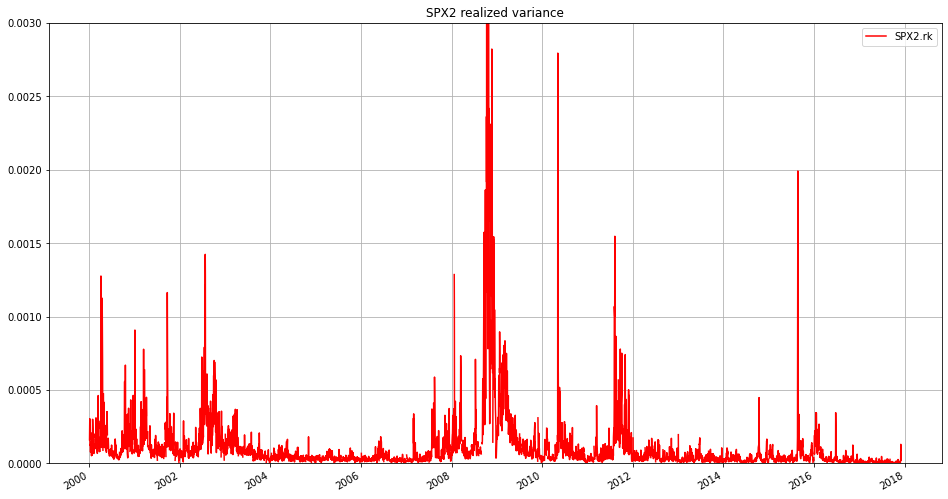

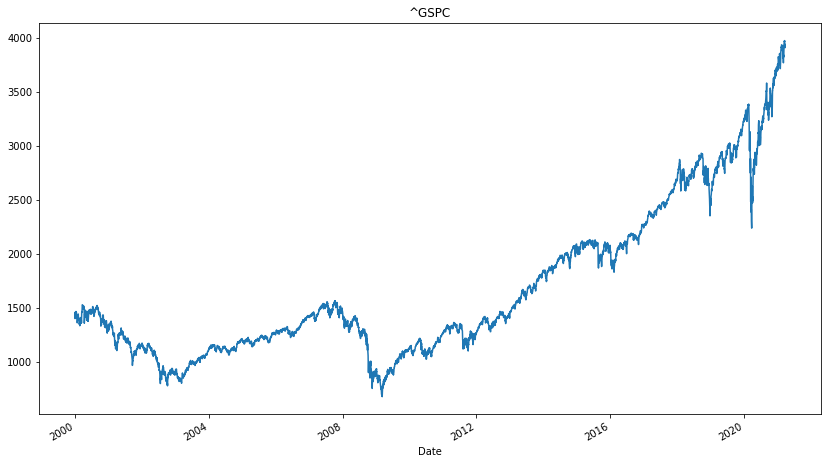

In [ ]:
RV1, RV_SPX = read_realized_variance("SPX2", DRIVE +'/OxfordManRealizedVolatilityIndices.csv')
# RV_SPX['sqrt']= np.sqrt(RV_SPX['SPX2.rk'])
# RV_SPX['log_sqrt'] = np.log(RV_SPX['sqrt'])

SPX = get_asset_data('^GSPC')



# 1 Model

In [ ]:
def del_Raw(rv, q, x): 
    return [np.mean(np.abs(rv['log_sqrt'] - rv['log_sqrt'].shift(lag)) ** q)
            for lag in x]

def dlsig2(sig, x, pr=False):
    if pr:
        a= np.array([(sig-sig.shift(lag)).dropna() for lag in x])
        a=a ** 2
    return [np.mean((sig-sig.shift(lag)).dropna() ** 2) for lag in x]

def H(rv1):
    h = list()
    nu = list()
    x = np.arange(1, 100)
    for col in rv1.columns:
        sig = rv1[col]
        sig = np.log(np.sqrt(sig))
        sig = sig.dropna()
        model = np.polyfit(np.log(x), np.log(dlsig2(sig, x)), 1)
        nu.append(np.sqrt(np.exp(model[1])))
        h.append(model[0]/2.)
        
    return pd.DataFrame({'names':rv1.columns, 'h_est': h, 'nu_est': nu})

# implementation of variance forecast
def c_tilde(h):
    return scsp.gamma(3. / 2. - h) / scsp.gamma(h + 1. / 2.) * scsp.gamma(2. - 2. * h)

def forecast_XTS(rvdata, h, date, nLags, delta, nu):
    i = np.arange(nLags)
    cf = 1./((i + 1. / 2.) ** (h + 1. / 2.) * (i + 1. / 2. + delta))
    ldata = rvdata.truncate(after=date)
    l = len(ldata)
    ldata = np.log(ldata.iloc[l - nLags:])
    ldata['cf'] = np.fliplr([cf])[0]
    # print ldata
    ldata = ldata.dropna()
    fcst = (ldata.iloc[:, 0] * ldata['cf']).sum() / sum(ldata['cf'])
    
    return math.exp(fcst + 2 * nu ** 2 * c_tilde(h) * delta ** (2 * h))

In [ ]:
H_RV = H(RV1)
H_RV

,names,h_est,nu_est
0,SPX2.rk,0.129279,0.324802
1,FTSE2.rk,0.140566,0.267038
2,N2252.rk,0.110684,0.326482
3,GDAXI2.rk,0.145953,0.277026
4,RUT2.rk,NaN,NaN
5,AORD2.rk,0.081706,0.358325
6,DJI2.rk,0.127363,0.318882
7,IXIC2.rk,NaN,NaN
8,FCHI2.rk,0.127367,0.292810
9,HSI2.rk,0.098814,0.281513


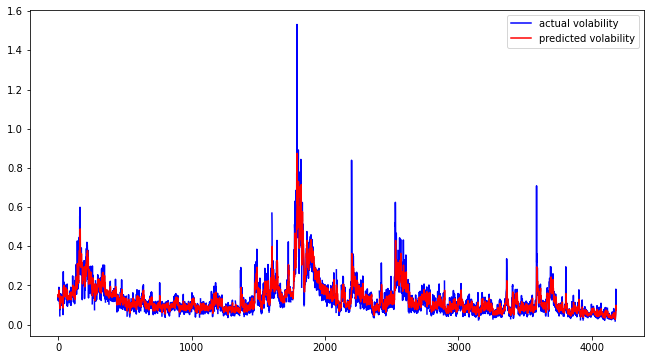

In [ ]:
RV_SPX = pd.DataFrame(RV1['SPX2.rk'])
NU  = H_RV['nu_est'][0] # Vol of vol estimate for SPX
H_EST = H_RV['h_est'][0] 
N = len(RV_SPX)
DELTA = 1
NLAGS = 500
DATES = RV_SPX.iloc[NLAGS:N-DELTA].index
rv_predict = [forecast_XTS(RV_SPX, h=H_EST, date=d, nLags=NLAGS,
                           delta=DELTA, nu=NU) for d in DATES]
rv_actual = RV_SPX.iloc[NLAGS+DELTA:N].values

plt.figure(figsize=(11, 6))
vol_actual = np.sqrt(np.multiply(rv_actual,252))
vol_predict = np.sqrt(np.multiply(rv_predict,252))
plt.plot(vol_actual, c="b", label='actual volability')
plt.plot(vol_predict, c="r", label='predicted volability')
plt.legend()

In [ ]:
df_pred_model = pd.DataFrame({
    'dates': DATES.values,
    'vol_actual': vol_actual.flatten(), 
    'vol_predict': vol_predict.flatten()})
df_pred_model

,dates,vol_actual,vol_predict
0,2001-12-04,0.150887,0.142477
1,2001-12-05,0.123193,0.154627
2,2001-12-06,0.142939,0.143037
3,2001-12-07,0.132488,0.150524
4,2001-12-10,0.146638,0.146763
...,...,...,...
4177,2017-11-28,0.065370,0.043109
4178,2017-11-29,0.071855,0.053135
4179,2017-11-30,0.181080,0.059936
4180,2017-12-01,0.076230,0.098874


In [ ]:
MODEL_PRED_FILE = 'OxfordManPredictedVolatility.csv'


In [ ]:
df_pred_model.to_csv(DRIVE+'/'+MODEL_PRED_FILE,
                     index=False, sep=',')

# 2 Deep learning


In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, LeakyReLU, LSTM
import tensorflow.keras.backend as K

In [ ]:
# From Deep Learning for Time Series Forecasting (c) Jason Brownlee

#split a univariate sequence into samples
def split_sequence_univariate(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
            
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


# Transforms a 2d-X and y to 3d X and y


# split a multivariate sequence into samples
def split_sequences_multivariate(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
# find the end of this pattern
        end_ix = i + n_steps
# check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
# gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, 0]
        X.append(seq_x)
        y.append(seq_y.flatten())
    return np.array(X), np.array(y)

In [ ]:
X_full = RV_SPX['SPX2.rk'].dropna().values.reshape((-1, 1))

## 2.1 Choix de modèle : LSTM avec activation tanh.

In [ ]:
N_I=100 # length of LSTM input
BATCH_SIZE=64
NEURONS=128
EPOCHS=200

T_IN=BATCH_SIZE*20
DT=111                     # time between calibrations
DT_orig=DT

def run_lstm(dataset, len_seq, units, epochs, batch, patience=2):
    x_sample,y_sample = split_sequence_univariate(dataset,len_seq) # single feature
    x_sample,y_sample = x_sample[:batch * (len(x_sample) // batch)], y_sample[:batch * (len(x_sample) // batch)]
    print(x_sample.shape)
    print(y_sample.shape)
    batches = tf.data.Dataset.from_tensor_slices((x_sample, y_sample)).shuffle(x_sample.shape[0]).batch(batch)

    model = Sequential([
        # Shape [batch, time, features] => [batch, time, lstm_units]
        LSTM(units, input_shape=(len_seq,1), return_sequences=False),
        # Shape => [batch, time, features]
        Dense(1, activation='tanh')
    ])
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
    #                                                 patience=patience,
    #                                                 mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=tf.optimizers.Adam(),
                    metrics=[tf.metrics.MeanAbsoluteError()])
    print(model.summary())

    history = model.fit(batches, epochs=epochs, verbose=0)
                        # callbacks=[early_stopping])
    print('*** model training done ***')
    
    plt.plot(np.log(history.history['loss']))
    plt.xlabel('epoch')
    plt.ylabel('mse')

    return model


(4352, 100, 1)
(4352, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
None
*** model training done ***


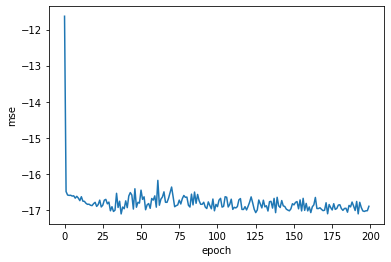

In [ ]:
LSTM = run_lstm(X_full, N_I, NEURONS, EPOCHS, BATCH_SIZE)

## 2.2 LSTM univariate

(4381, 1)


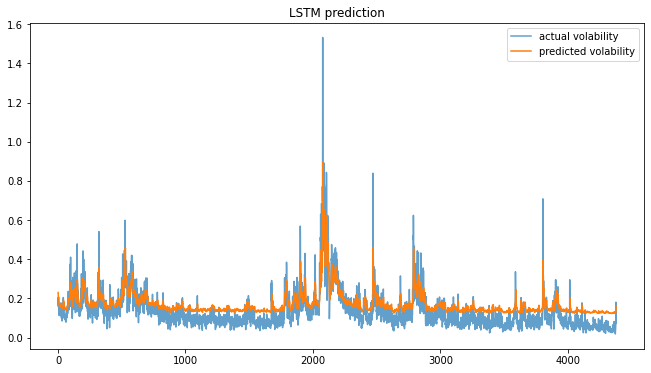

In [ ]:
sample, target = split_sequence_univariate(X_full,N_I)
vol_predict_lstm = LSTM(sample, training=False)
print(vol_predict_lstm.shape)
plt.figure(figsize=(11, 6))
plt.title('LSTM prediction')
plt.plot(np.sqrt(252 * target), alpha=0.7, label='actual volability')
plt.plot(np.sqrt(252 * vol_predict_lstm), label='predicted volability')
plt.legend()

In [ ]:

def run_lstm_multivar(dataset, len_seq, units, epochs, batch, patience=2):
    x_sample,y_sample = split_sequences_multivariate(dataset,len_seq) # single feature
    x_sample,y_sample = x_sample[:batch * (len(x_sample) // batch), :], y_sample[:batch * (len(x_sample) // batch), :]
    print(x_sample.shape)
    print(y_sample.shape)
    batches = tf.data.Dataset.from_tensor_slices((x_sample, y_sample)).shuffle(x_sample.shape[0]).batch(batch)

    model = Sequential([
        # Shape [batch, time, features] => [batch, time, lstm_units]
        LSTM(units, input_shape=(len_seq,x_sample.shape[-1]), return_sequences=False),
        # Shape => [batch, time, features]
        Dense(1, activation='tanh')
    ])
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
    #                                                 patience=patience,
    #                                                 mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=tf.optimizers.Adam(),
                    metrics=[tf.metrics.MeanAbsoluteError()])
    print(model.summary())

    history = model.fit(batches, epochs=epochs, verbose=0)
                        # callbacks=[early_stopping])
    print('*** model training done ***')
    
    plt.plot(np.log(history.history['loss']))
    plt.xlabel('epoch')
    plt.ylabel('mse')

    return model

(4352, 100, 2)
(4352, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               67072     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 67,201
Trainable params: 67,201
Non-trainable params: 0
_________________________________________________________________
None
*** model training done ***


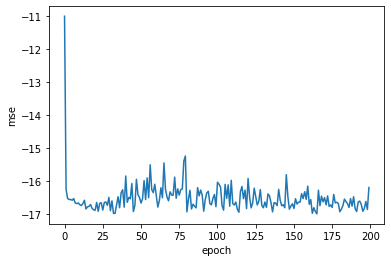

In [ ]:
from datetime import datetime
def is_third_friday(s):
    # d = datetime.strptime(s, '%Y-%m-%d')
    return 1 if (s.weekday() == 4 and 15 <= s.day <= 21) else 0


X_full = pd.DataFrame(RV_SPX['SPX2.rk'].dropna())
X_full['friday3'] = pd.Series([is_third_friday(s) for s in X_full.index], index=X_full.index)

LSTM_mul = run_lstm_multivar(X_full.values, N_I, NEURONS, EPOCHS, BATCH_SIZE)

## 2.3 LSTM multivariate


(4381, 1)


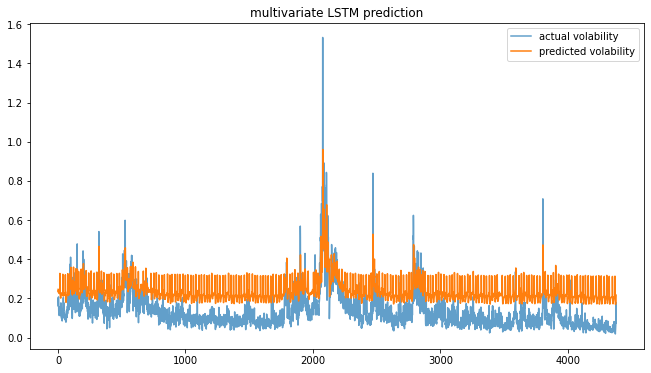

In [ ]:
sample, target = split_sequences_multivariate(X_full.values,N_I)
vol_predict_lstm = LSTM_mul(sample, training=False)
print(vol_predict_lstm.shape)
plt.figure(figsize=(11, 6))
plt.title('multivariate LSTM prediction')
plt.plot(np.sqrt(252 * target), alpha=0.7, label='actual volability')
plt.plot(np.sqrt(252 * vol_predict_lstm), label='predicted volability')
plt.legend()

# 3 DL + Model

(3712, 100, 3)
(3712, 1)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128)               67584     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 67,713
Trainable params: 67,713
Non-trainable params: 0
_________________________________________________________________
None
*** model training done ***


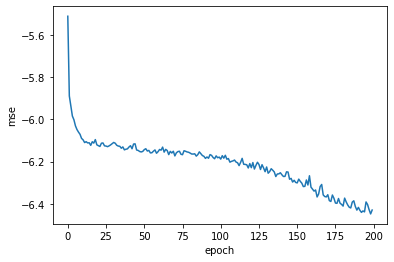

In [ ]:
### Read model prediction result ###
df_pred_model = pd.read_csv(DRIVE+'/'+MODEL_PRED_FILE, index_col='dates')
X_full = pd.DataFrame(RV_SPX['SPX2.rk'].dropna())
X_full = pd.merge(df_pred_model, X_full, left_index=True, right_index=True)
X_full = X_full.dropna()
LSTM_comb = run_lstm_multivar(X_full.values, N_I, NEURONS, EPOCHS, BATCH_SIZE)

(3746, 1)


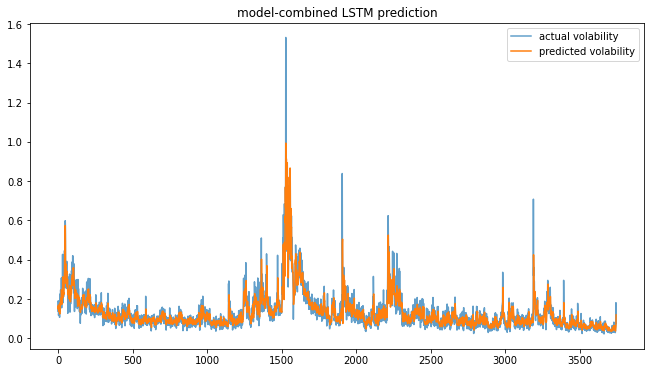

In [ ]:
sample, target = split_sequences_multivariate(X_full.values,N_I)
vol_predict_lstm = LSTM_comb(sample, training=False)
print(vol_predict_lstm.shape)
plt.figure(figsize=(11, 6))
plt.title('model-combined LSTM prediction')
plt.plot(target, alpha=0.7, label='actual volability')
plt.plot(vol_predict_lstm, label='predicted volability')
plt.legend()

In [ ]:
df_pred_comb = pd.DataFrame({
    'dates': X_full.index.values[:len(target)],
    'vol_actual': target.flatten(), 
    'vol_predict': vol_predict_lstm.numpy().flatten()})
df_pred_comb

,dates,vol_actual,vol_predict
0,2001-12-04,0.138207,0.159006
1,2001-12-05,0.190696,0.148251
2,2001-12-06,0.181139,0.167544
3,2001-12-07,0.116746,0.169753
4,2001-12-10,0.123690,0.142698
...,...,...,...
3741,2017-06-30,0.049650,0.036703
3742,2017-07-05,0.065370,0.044152
3743,2017-07-06,0.071855,0.055346
3744,2017-07-07,0.181080,0.063828


In [ ]:
COMB_PRED_FILE = 'OxfordManCOMBPredictedVolatility.csv'

In [ ]:
df_pred_model.to_csv(DRIVE+'/'+COMB_PRED_FILE,
                     index=False, sep=',')